# Setup

In [8]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)
np.random.seed(10)

# Variables & Training/Equation Data

Text(0.5, 0, 'Time (s)')

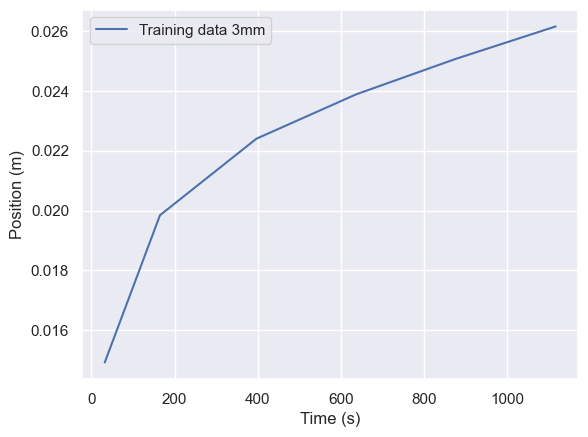

In [9]:
# Different variables for problem
r = 0.005                           # Radius of droplet in [m]
V = (4/3)*np.pi*(r**3)              # Volume of droplet in [m^3]
mu_0 = 1.256637*(10**-6)            # Permeability of free space [m*kg/(s*A)]
eta = 50                            # Viscosity in [Pa*s]
M = magnetization                   # Magnetization in [Oe]
H = magnetic_field                  # Magnetic field in [KA/m]
dH_dx = magnetic_field_deriv        # Derivative of magnetic field with respect to distance in [KA/m^2]

# Grab training data
train_t, train_x = position_3mm_droplet()
train_t_scaled = (train_t - np.min(train_t)) / (np.max(train_t) - np.min(train_t))
train_x_scaled = (train_x - np.min(train_x)) / (np.max(train_x) - np.min(train_x))

# Plot training data
plt.plot(train_t, train_x)
plt.legend(['Training data 3mm'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')

# Physics Loss Model

In [4]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 2000, steps=2000,).view(-1, 1).requires_grad_(True).to(DEVICE)
    xs = model(ts)
    dx = grad(xs, ts)[0]
    pde = (V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta) - dx
    
    return torch.mean(pde**2)
    

# Trying Different Loss Weights for Physics Loss + Data Loss

In [ ]:
different_lambdas = torch.linspace(0, 500, 25)
losses_each_lambda = torch.empty(len(different_lambdas))

for i in range(0, len(different_lambdas)):
    net = Net(1,1, loss2=physics_loss, epochs=5000, loss2_weight=different_lambdas[i], lr=1e-5).to(DEVICE)
    losses_each_lambda[i] = net.fit(train_t, train_x)[-1]

plt.plot(different_lambdas, losses_each_lambda)
plt.legend(['Loss vs. Lambda'])
plt.ylabel('Loss')
plt.xlabel('Lambda')

# Learn the Model

Epoch 0/5000, data loss: 0.46, physics loss: 0.09
Epoch 500/5000, data loss: 0.28, physics loss: 0.00
Epoch 1000/5000, data loss: 0.12, physics loss: 0.00
Epoch 1500/5000, data loss: 0.04, physics loss: 0.00
Epoch 2000/5000, data loss: 0.01, physics loss: 0.00
Epoch 2500/5000, data loss: 0.01, physics loss: 0.00
Epoch 3000/5000, data loss: 0.01, physics loss: 0.00
Epoch 3500/5000, data loss: 0.01, physics loss: 0.00
Epoch 4000/5000, data loss: 0.00, physics loss: 0.00
Epoch 4500/5000, data loss: 0.00, physics loss: 0.00


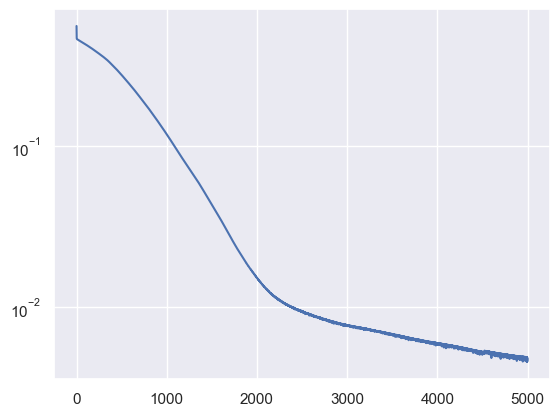

In [6]:
net = Net(1,1, loss2=physics_loss, epochs=5000, loss2_weight=1, lr=1e-5).to(DEVICE)
losses = net.fit(train_t, train_x)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

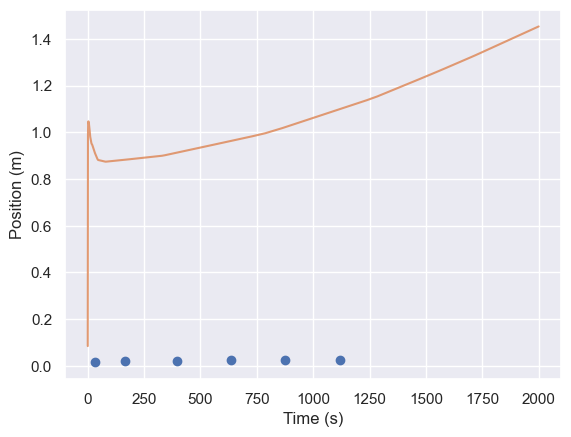

In [7]:
times = np.linspace(0, 2000, 2000)
preds = net.predict(times)

plt.plot(train_t, train_x, 'o')
plt.plot(times, preds, alpha=0.8)
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')